In [ ]:
# Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Load and Preprocess Data

In [21]:
# Define column names
columns = [
    'filename', 'label', 'statement', 'subject', 'speaker', 
    'job_title', 'state', 'party', 'true_counts', 'false_counts',
    'half_true_counts', 'barely_true_counts', 'pants_fire_counts', 'context'
]

# Load the data
df = pd.read_csv('train.tsv', sep='\t', header=None, names=columns)
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (10240, 14)


,filename,label,statement,subject,speaker,job_title,state,party,true_counts,false_counts,half_true_counts,barely_true_counts,pants_fire_counts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [22]:
def categorize_subject(subject):
    """Categorize subjects into broader categories"""
    if pd.isna(subject):
        return 'other'
    
    subject = subject.lower()
    
    if any(word in subject for word in ['health', 'medicare', 'medicaid']):
        return 'healthcare'
    elif any(word in subject for word in ['economy', 'jobs', 'unemployment', 'taxes', 'budget']):
        return 'economy'
    elif any(word in subject for word in ['education', 'school', 'student']):
        return 'education'
    elif any(word in subject for word in ['immigration', 'border']):
        return 'immigration'
    elif any(word in subject for word in ['military', 'war', 'veteran']):
        return 'military'
    elif any(word in subject for word in ['environment', 'climate', 'energy']):
        return 'environment'
    elif any(word in subject for word in ['campaign', 'election', 'voting']):
        return 'political_process'
    else:
        return 'other'

# Clean and preprocess the data
def clean_data(df):
    """Clean and preprocess the dataframe"""
    # Drop rows with missing values in key columns
    df = df.dropna(subset=['label', 'statement', 'subject', 'party'])
    
    # Convert numeric columns
    numeric_columns = ['true_counts', 'false_counts', 'half_true_counts', 
                      'barely_true_counts', 'pants_fire_counts']
    
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    
    # Create derived features
    df['statement_length'] = df['statement'].str.len()
    df['total_fact_checks'] = (df['true_counts'] + df['false_counts'] + 
                              df['half_true_counts'] + df['barely_true_counts'] + 
                              df['pants_fire_counts'])
    df['subject_category'] = df['subject'].apply(categorize_subject)
    
    # Clean party column
    df['party'] = df['party'].fillna('none')
    df['party'] = df['party'].astype(str).str.lower().str.strip()
    df['party'] = df['party'].replace('', 'none')
    
    # Calculate truthfulness ratio
    df['truthfulness_ratio'] = df['true_counts'] / (df['total_fact_checks'] + 1)
    
    return df

# Apply preprocessing
df = clean_data(df)
print("\nFeature summary:")
df.describe()


Feature summary:


,true_counts,false_counts,half_true_counts,barely_true_counts,pants_fire_counts,statement_length,total_fact_checks,truthfulness_ratio
count,10238.000000,10238.000000,10238.000000,10238.000000,10238.000000,10238.000000,10238.000000,10238.000000
mean,11.533210,13.286482,17.133718,16.434265,6.201407,106.860813,64.589080,0.160704
std,18.973764,24.112936,35.846511,36.151688,16.128927,59.750418,115.737547,0.137175
min,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000,2.000000,0.000000
50%,2.000000,2.000000,3.000000,3.000000,1.000000,99.000000,11.000000,0.172185
75%,12.000000,12.000000,13.000000,11.000000,5.000000,132.000000,65.000000,0.230769
max,70.000000,114.000000,160.000000,163.000000,105.000000,3192.000000,473.000000,0.666667


## 2. Feature Engineering and Data Splitting

In [23]:
def preprocess_features(df):
    """Preprocess features for machine learning"""
    encoders = {}
    df_processed = df.copy()
    
    # Encode categorical variables
    for col, prefix in [('label', 'label'), ('subject_category', 'subject'), 
                       ('party', 'party'), ('state', 'state'), ('job_title', 'job_title')]:
        le = LabelEncoder()
        df_processed[f'{col}_encoded'] = le.fit_transform(df[col])
        encoders[prefix] = le
    
    feature_cols = [
        'subject_category_encoded', 'party_encoded', 'state_encoded', 'job_title_encoded',
        'true_counts', 'false_counts', 'half_true_counts', 
        'barely_true_counts', 'pants_fire_counts', 'total_fact_checks',
        'statement_length', 'truthfulness_ratio'
    ]
    
    X = df_processed[feature_cols]
    y = df_processed['label_encoded']
    
    return X, y, encoders, df_processed

# Prepare features and split data
X, y, encoders, df_processed = preprocess_features(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Save encoders and scaler for later use
joblib.dump(encoders, 'models/encoders.joblib')
joblib.dump(scaler, 'models/scaler.joblib')

Training set shape: (7166, 12)
Testing set shape: (3072, 12)


['models/scaler.joblib']

## 3. Model Training and Evaluation

In [24]:
# Train and evaluate models
models = {}
predictions = {}
model_scores = {}

# 1. Support Vector Machine
print("Training Support Vector Machine...")
svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

models['SVM'] = svm
predictions['SVM'] = svm_pred
model_scores['SVM'] = {'probabilities': svm.predict_proba(X_test)}


# 2. Naive Bayes
print("\nTraining Naive Bayes...")
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_pred = nb.predict(X_test)

models['Naive Bayes'] = nb
predictions['Naive Bayes'] = nb_pred
model_scores['Naive Bayes'] = {'probabilities': nb.predict_proba(X_test)}

# 3. Random Forest
print("\nTraining Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

models['Random Forest'] = rf
predictions['Random Forest'] = rf_pred
model_scores['Random Forest'] = {
    'probabilities': rf.predict_proba(X_test),
    'feature_importance': rf.feature_importances_
}

Training Support Vector Machine...

Training Naive Bayes...

Training Random Forest...


In [25]:
# Evaluate models
print("Model Evaluation Results:\n")

for model_name, pred in predictions.items():
    accuracy = accuracy_score(y_test, pred)
    print(f"\n{model_name}:")
    print(f"Accuracy: {accuracy:.3f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, pred, 
                              target_names=encoders['label'].classes_))

Model Evaluation Results:


SVM:
Accuracy: 0.235

Classification Report:
              precision    recall  f1-score   support

 barely-true       0.00      0.00      0.00       496
       false       0.23      0.50      0.32       598
   half-true       0.23      0.58      0.33       634
 mostly-true       0.23      0.06      0.09       589
  pants-fire       0.59      0.09      0.15       252
        true       0.00      0.00      0.00       503

    accuracy                           0.24      3072
   macro avg       0.21      0.20      0.15      3072
weighted avg       0.19      0.24      0.16      3072


Naive Bayes:
Accuracy: 0.257

Classification Report:
              precision    recall  f1-score   support

 barely-true       0.37      0.61      0.46       496
       false       0.22      0.08      0.11       598
   half-true       0.23      0.09      0.13       634
 mostly-true       0.22      0.11      0.14       589
  pants-fire       0.22      0.31      0.26       252
     

## 4. Visualizations

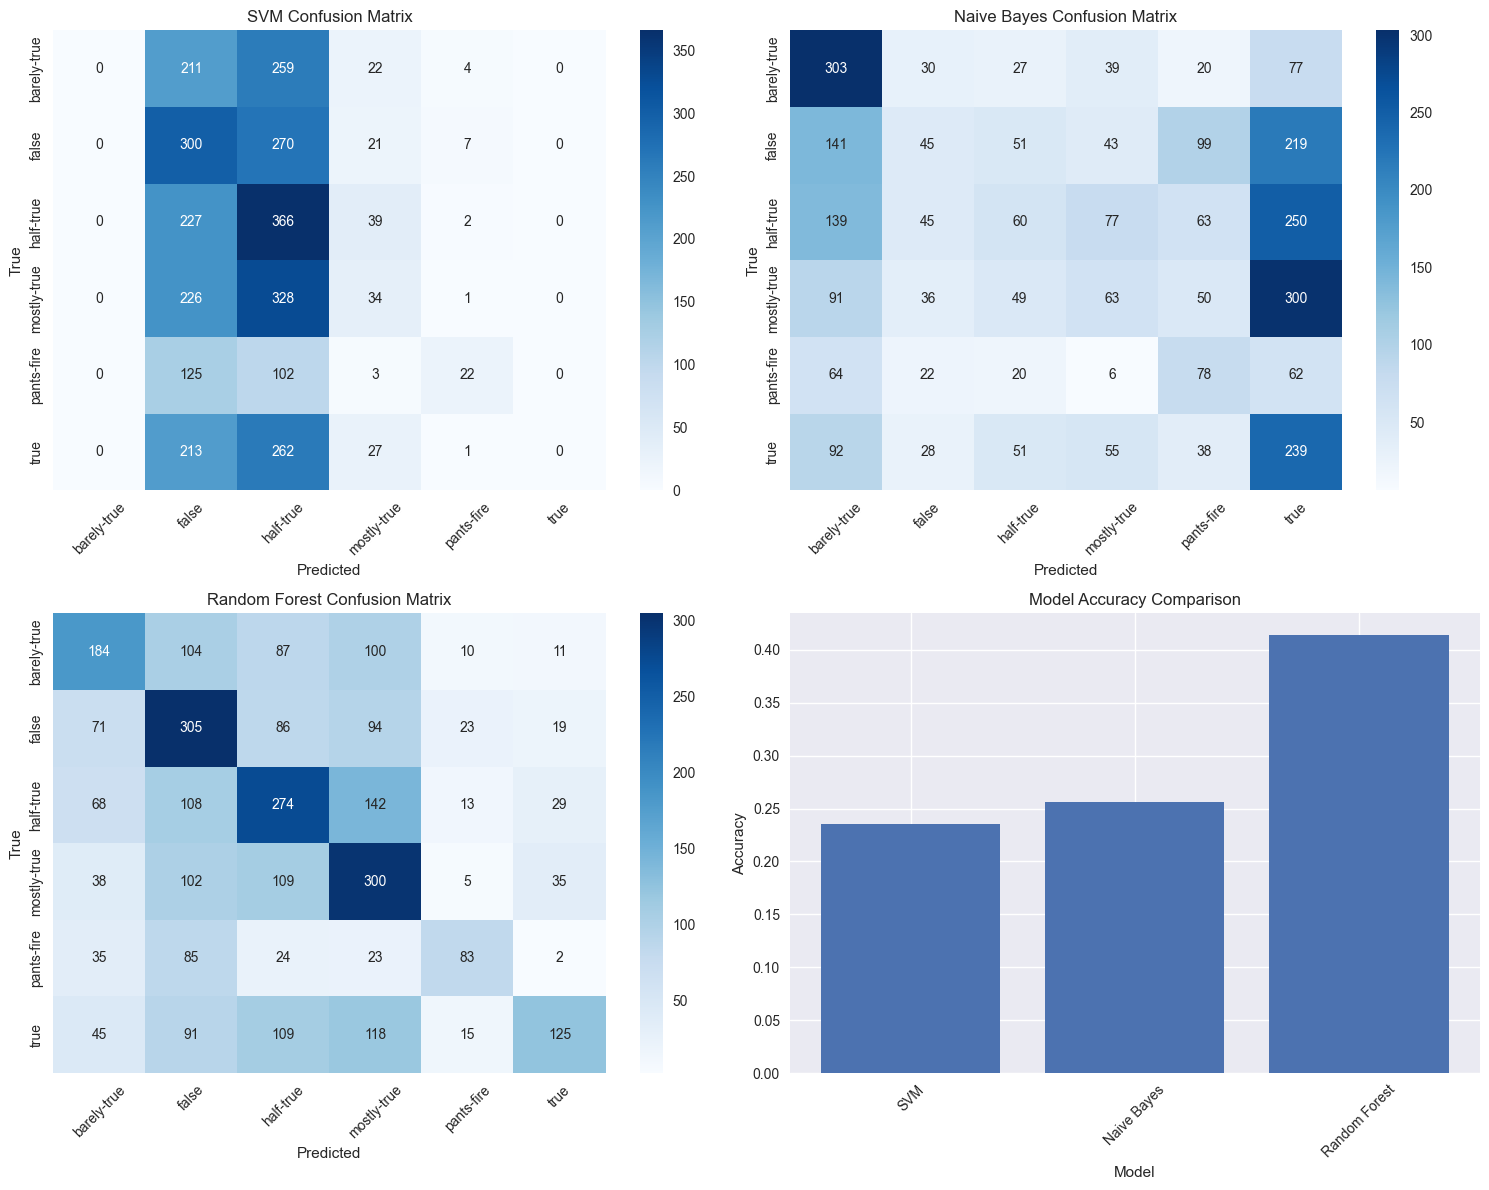

In [26]:
# Set up the visualization style
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrices
for idx, (model_name, pred) in enumerate(predictions.items()):
    if idx < 3:  # We have 3 models
        plt.subplot(2, 2, idx+1)
        cm = confusion_matrix(y_test, pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=encoders['label'].classes_,
                   yticklabels=encoders['label'].classes_)
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.xticks(rotation=45)

# 2. Model Comparison (Accuracy)
accuracies = [accuracy_score(y_test, pred) for pred in predictions.values()]
plt.subplot(2, 2, 4)
plt.bar(predictions.keys(), accuracies)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

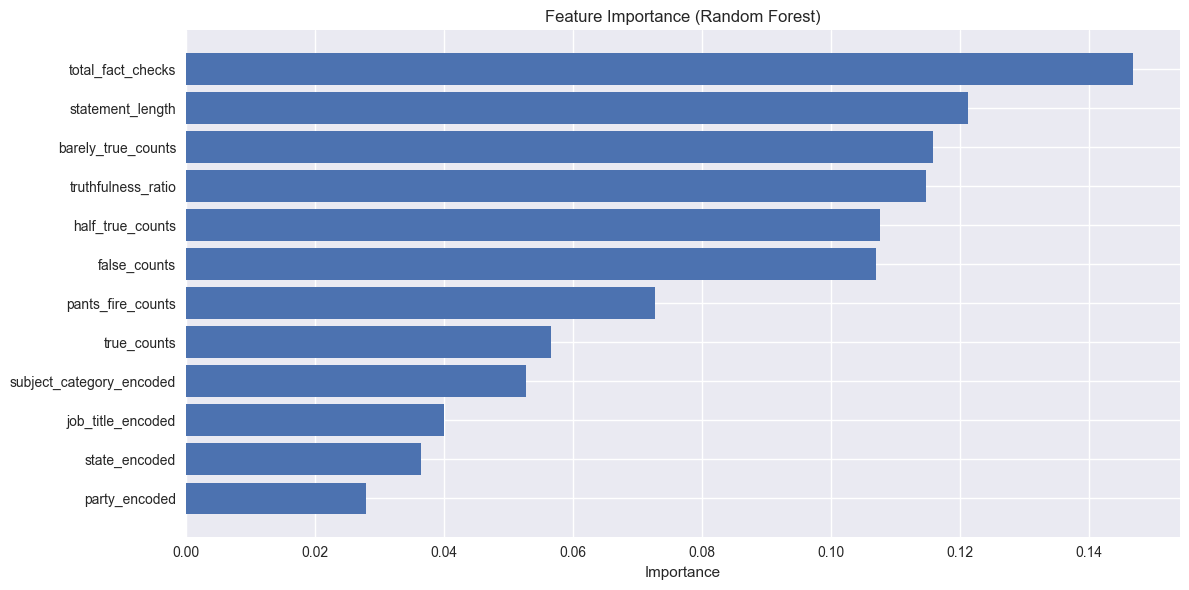

In [27]:
# Feature importance visualization (for Random Forest)
feature_importance = model_scores['Random Forest']['feature_importance']
feature_names = X.columns

plt.figure(figsize=(12, 6))
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=True)

plt.barh(range(len(importance_df)), importance_df['importance'])
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

## 5. Save Models

In [28]:
# Create models directory if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

# Save all models
for model_name, model in models.items():
    filename = f'models/{model_name.lower().replace(" ", "_")}.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Saved {model_name} to {filename}")

Saved SVM to models/svm.pkl
Saved Naive Bayes to models/naive_bayes.pkl
Saved Random Forest to models/random_forest.pkl
